In [1]:
city='Chengdu'
city_cn='成都'

# Developer Salary in Nanjing 南京程序员工资调查
我在4月1日到3日之间，抓取了某招聘网站的软件和互联网类招聘数据40万条，其中通过程序判断为程序员的14万条。地域方面，我选择了24个主要城市。不过本文只以一线城市为研究对象。这样是为了和我2017年6月的数据做对比。

提到2017年的文章，现在居然还有很多人，把这篇文章拿出来炒作。对于社会来说，可气的是，他们直接把2017改成2019，就发表了，这不是骗人么？！对于我来说，可气的是，他们转载居然还冒充是原创，是可忍熟不可忍！

In [2]:
import pandas as pd
import sys
sys.path.append('..')
import db
import inspect
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
%matplotlib inline

In [3]:
conn=db.get_conn()
data_original=pd.read_sql(sql="select * from _51jobs where monthly_salary>0 and monthly_salary<15 and city_{}=1".format(city), con=conn)
conn.close()

In [4]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [5]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

# Unilateral Stats 总体统计

有数据可知，程序员向一线城市集中的趋势非常明显。

According to the statistics, significant amount of developers are in the first tier cities.

In [6]:
salary_mean=data.monthly_salary.mean()*10000
salary_median=data.monthly_salary.median()*10000
q=np.quantile(data.monthly_salary,[0.025,0.975])*10000
print('2019年{}程序员的平均工资为{:.0f}元，工资中位数为{:.0f}元，其中95%的人的工资位于{:.0f}到{:.0f}元之间。'
      .format(city_cn,salary_mean, salary_median, q[0], q[1]))

2019年成都程序员的平均工资为11896元，工资中位数为11500元，其中95%的人的工资位于3750到27083元之间。


In [7]:
print('In 2019, Developers in {} earn {:.0f} Yuan as average, '
      'the median is {:.0f} Yuan, 95% of them earn between {:.0f} and {:.0f} Yuan.'
      .format(city,salary_mean, salary_median, q[0], q[1]))

In 2019, Developers in Chengdu earn 11896 Yuan as average, the median is 11500 Yuan, 95% of them earn between 3750 and 27083 Yuan.


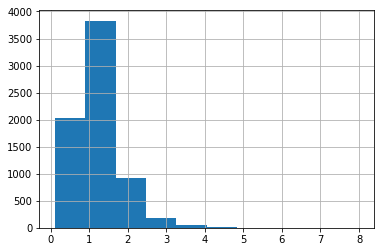

In [8]:
data.monthly_salary.hist()

It does not look like normal distribution.

In [9]:
from scipy import stats

In [10]:
stats.normaltest(data.monthly_salary)

NormaltestResult(statistic=3400.511719984244, pvalue=0.0)

null hypothesis: x comes from a normal distribution
    
p=0

The null hypothesis can be rejected

conclusion: data is not normally distributed.

Zoom in

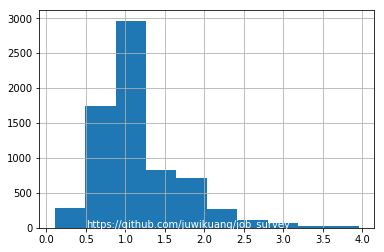

In [11]:
data[data.monthly_salary<4].monthly_salary.hist()
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0,0), xytext=(0.5, 20), color='white')
plt.show()

## Role 角色

In [12]:
def get_sub_stats(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    count=[]
    for feature in features:
        salary_mean.append(data[data[feature]==1].monthly_salary.mean()*10000)
        salary_median.append(data[data[feature]==1].monthly_salary.median()*10000)
        count.append(data[data[feature]==1].shape[0])
    sub_data=pd.DataFrame()
    sub_data[prefix]=[f.replace(prefix,'') for f in features]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_median']=salary_median
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

In [13]:
def add_category_column(data, prefix):
    prefix_=prefix+"_"
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    data.loc[:,prefix]=['']*data.shape[0]
    for feature in features:
        data.loc[data[feature]==1,prefix]=feature.replace(prefix_,'')
    return data

In [14]:
data_career=get_sub_stats(data,'career_')
data_career.style.format({"percentage":"{:.2%}"})

,career_,salary_mean,salary_median,head_count,percentage
1,architect,18350.3,17500,291,4.05%
0,algorithm,17406.2,17083.3,758,10.54%
2,software_engineer,11178.7,10500,6141,85.41%


# 编程语言

In [15]:
data_pl=get_sub_stats(data,'pl_')
data_pl.style.format({"percentage":"{:.2%}"})

,pl_,salary_mean,salary_median,head_count,percentage
6,haskell,31666.7,31666.7,1,0.01%
0,assembly,17604.9,15000,54,0.57%
18,rust,17128.2,17500,13,0.14%
19,scala,17106.8,16500,71,0.74%
25,r,16596.8,12500,31,0.32%
17,ruby,16247.4,14500,32,0.33%
12,matlab,16151,15000,181,1.89%
14,perl,15002.8,12500,65,0.68%
16,python,14921.7,12500,784,8.21%
4,go,14565.7,12500,755,7.90%


# 教育

In [16]:
data_edu=get_sub_stats(data,'edu_')
data_edu.style.format({"percentage":"{:.2%}"})

,edu_,salary_mean,salary_median,head_count,percentage
5,phd,23750,22500,6,0.10%
3,master,17568.8,17500,195,3.37%
1,bachelor,12802.7,12000,3469,59.99%
4,middle_school,10000,10000,2,0.03%
0,associate,9909.45,9000,2089,36.12%
2,high_school,8893.94,8250,22,0.38%


In [17]:
salary_phd=data[data.edu_phd==1].monthly_salary * 10000
salary_master=data[data.edu_master==1].monthly_salary * 10000
salary_bachelor=data[data.edu_bachelor==1].monthly_salary * 10000
salary_associate=data[data.edu_associate==1].monthly_salary * 10000

In [18]:
print('大专，本科，硕士，博士的平均工资分别是{:.0f}，{:.0f}，{:.0f}，{:.0f}。中位数分别是{:.0f}， {:.0f}，{:.0f}， {:.0f}。'.format(
    salary_associate.mean(),salary_bachelor.mean(),salary_master.mean(),salary_phd.mean(),
    salary_associate.median(),salary_bachelor.median(),salary_master.median(),salary_phd.median()))

大专，本科，硕士，博士的平均工资分别是9909，12803，17569，23750。中位数分别是9000， 12000，17500， 22500。


In [19]:
stats.f_oneway(salary_phd, salary_master)

F_onewayResult(statistic=4.602284295431452, pvalue=0.03314107457705273)

In [20]:
stats.f_oneway(salary_master, salary_bachelor)

F_onewayResult(statistic=111.23781692887418, pvalue=1.2192245184207833e-25)

In [21]:
stats.f_oneway(salary_bachelor, salary_associate)

F_onewayResult(statistic=352.50570349900823, pvalue=2.660907641064028e-76)

经过Oneway Anova Test，证明从大专到博士，学历每提高一级，工资都有显著的提高。

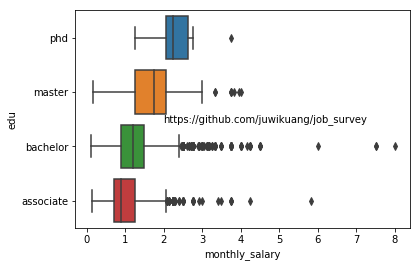

In [22]:
data=add_category_column(data,'edu')
order=['phd','master','bachelor','associate']
a=sns.boxplot(y='edu',x='monthly_salary',order=order,data=data[data.edu.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0.5,1.5), xytext=(2, 1.55))
plt.show()

# 工作经验 Working Experience

In [23]:
data_experience=get_sub_stats(data,'experience_')
data_experience.style.format({"percentage":"{:.2%}"})

,experience_,salary_mean,salary_median,head_count,percentage
0,10,36868.4,29000,19,0.27%
3,5_10,17411,16000,817,11.62%
2,3_5,12651.6,12000,2026,28.83%
4,no,10786.2,10000,1874,26.66%
1,1_3,9962.57,9000,2292,32.61%


In [24]:
salary_we_10=data[data.experience_10==1].monthly_salary * 10000
salary_we_5_10=data[data.experience_5_10==1].monthly_salary * 10000
salary_we_3_5=data[data.experience_3_5==1].monthly_salary * 10000
salary_we_1_3=data[data.experience_1_3==1].monthly_salary * 10000
salary_we_no=data[data.experience_no==1].monthly_salary * 10000

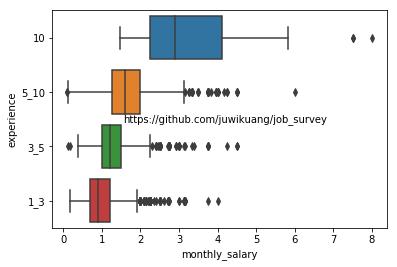

In [25]:
data=add_category_column(data,'experience')
order=['10','5_10','3_5','1_3']
sns.boxplot(y='experience',x='monthly_salary',order=order,data=data[data.experience.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(1.5,1.5), xytext=(1.55, 1.55))
plt.show()

# 公司 Company

## 公司性质 Company Type

In [26]:
data_company_type=get_sub_stats(data,'company_type_')
data_company_type.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,company_type_,salary_mean,salary_median,head_count,percentage
2,foreign_rep,18375,15000,4,0.06%
6,public_institution,16961,15833,51,0.77%
9,us_eu,13838,12500,273,4.14%
8,state,12475,12000,445,6.75%
0,foreign,12308,12500,204,3.09%
3,listed,11994,11500,558,8.46%
5,private,11478,10500,4904,74.34%
7,startup,10946,9500,146,2.21%
4,non_profit,9569,10417,12,0.18%
1,foreign_gov,nan,nan,0,0.00%


us_eu是欧美外企，startup是创业公司，listed是上市公司，state是国企，private是私企，foreign是非欧美外企，其他不足1000个样本的不管了。

## 公司规模 Company Size

In [27]:
data_company_size=get_sub_stats(data,'company_size_')
data_company_size.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,company_size_,salary_mean,salary_median,head_count,percentage
0,10000,15609,12500,230,3.28%
1,1000_5000,13655,12500,754,10.76%
5,500_1000,12752,12500,599,8.55%
4,5000_10000,12251,12250,96,1.37%
2,150_500,12053,11500,1773,25.31%
6,50_150,11459,10500,2150,30.69%
3,50,10470,9000,1404,20.04%


公司越大，工资越高

## 行业 Industry

In [28]:
data_industry=get_sub_stats(data,'industry_')
data_industry.style.format({"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}"})

,industry_,salary_mean,salary_median,head_count,percentage
6,logistic,12811,12500,170,2.05%
2,edu,12726,11500,419,5.05%
4,finance,12186,11500,291,3.51%
1,computer,11942,11500,6219,74.94%
5,gov,11845,10500,174,2.10%
10,trade,11428,10500,371,4.47%
9,service,11215,11500,95,1.14%
0,ads,10511,9000,117,1.41%
8,realestate,10495,10000,147,1.77%
7,medical,10412,9000,174,2.10%
